# Correct-out astrophysical variability of nova V606 Vul with RegressionCorrector

This notebook is created to address the referee's comments on the paper "TESS photometry of the nova eruption in V606 Vul: asymmetric photosphere and multiple ejections?" ([arXiv e-print](https://arxiv.org/abs/2311.04903)) submitted to ApJ. It illustrates how easily high-amplitude astrophysical variability can be corrected-out by blindly following a tutorial aimed at exoplanet lightcurve analysis.

We apply the tutorial (New link: https://lightkurve.github.io/lightkurve/tutorials/2-creating-light-curves/2-3-removing-scattered-light-using-regressioncorrector.html Web Archive link: https://web.archive.org/web/20240726181744/https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-removing-scattered-light-using-regressioncorrector.html  dead original link: https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-removing-scattered-light-using-regressioncorrector.html ) to TESS Sector 41 observations of Galactic nova V606 Vul to see what happens when RegressionCorrector is applied to this lightcurve. The trick is that V606 Vul is bright and showing high-aplitude irregular variability in addition to a low-amplitude (but still clearly visible in the raw ligtcurve) periodic signal.

*Do not follow this notebook for actual data analysis!!!*

This notebook aims to show how *not* to do things.

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
target = "V606 Vul"  # Galactic nova that erupted in 2021 (TESS Sector 41)
tpf = lk.search_tesscut(target, sector=41).download(cutout_size=(50, 50))

In [3]:
tpf

TessTargetPixelFile(TICID: V606 Vul)

In [4]:
aper = tpf.create_threshold_mask()

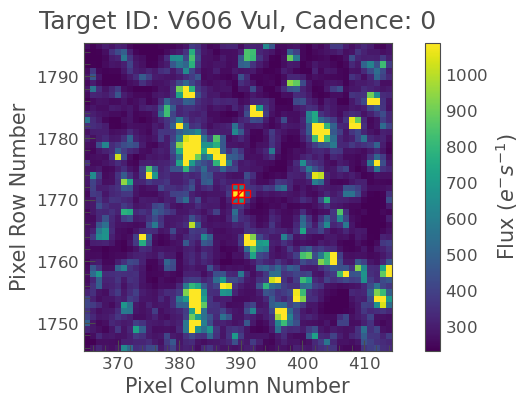

In [5]:
tpf.plot(aperture_mask=aper);

In [6]:
uncorrected_lc = tpf.to_lightcurve(aperture_mask=aper)

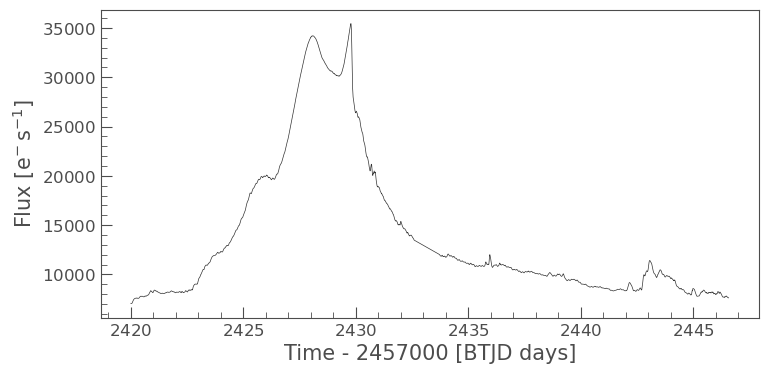

In [7]:
uncorrected_lc.plot();

In [8]:
regressors = tpf.flux[:, ~aper]

In [9]:
regressors.shape

(3658, 2493)

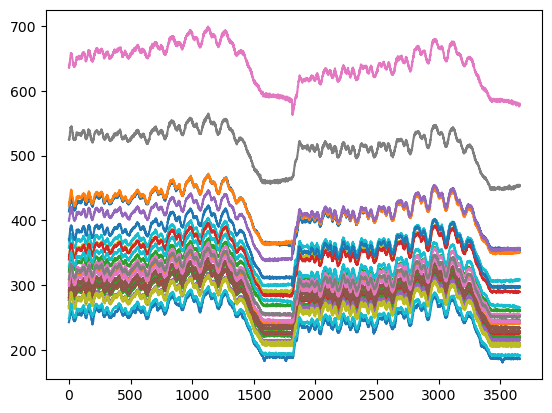

In [10]:
plt.plot(regressors[:, :30]);

In [11]:
from lightkurve.correctors import DesignMatrix
dm = DesignMatrix(regressors, name='regressors')

In [12]:
dm

regressors DesignMatrix (3658, 2493)

In [13]:
dm = dm.pca(5)

In [14]:
dm

regressors DesignMatrix (3658, 5)

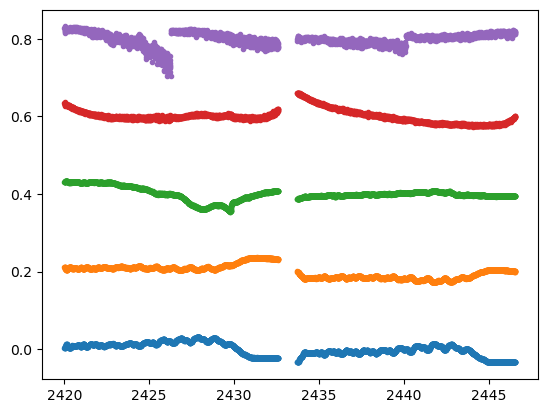

In [15]:
plt.plot(tpf.time.value, dm.values + np.arange(5)*0.2, '.');

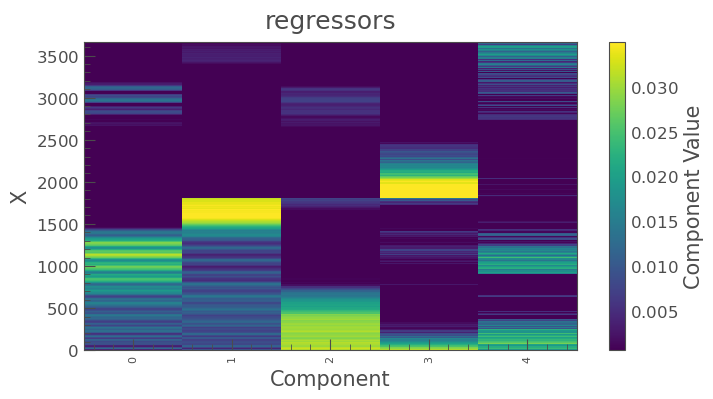

In [16]:
dm.plot();

In [17]:
dm = dm.append_constant()

In [18]:
from lightkurve.correctors import RegressionCorrector
corrector = RegressionCorrector(uncorrected_lc)

In [19]:
corrector

RegressionCorrector (ID: V606 Vul)

In [20]:
corrected_lc = corrector.correct(dm)

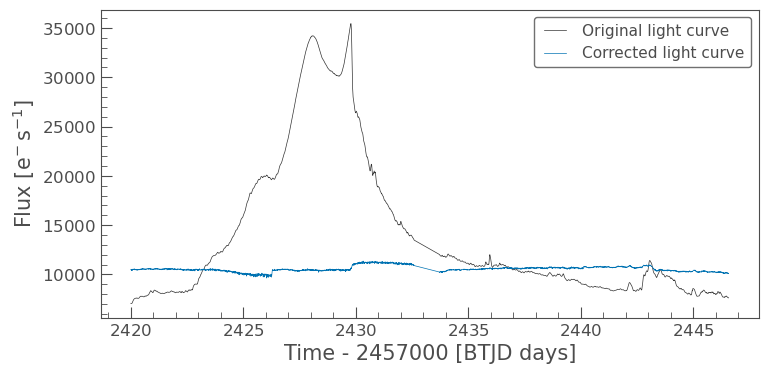

In [21]:
ax = uncorrected_lc.plot(label='Original light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');

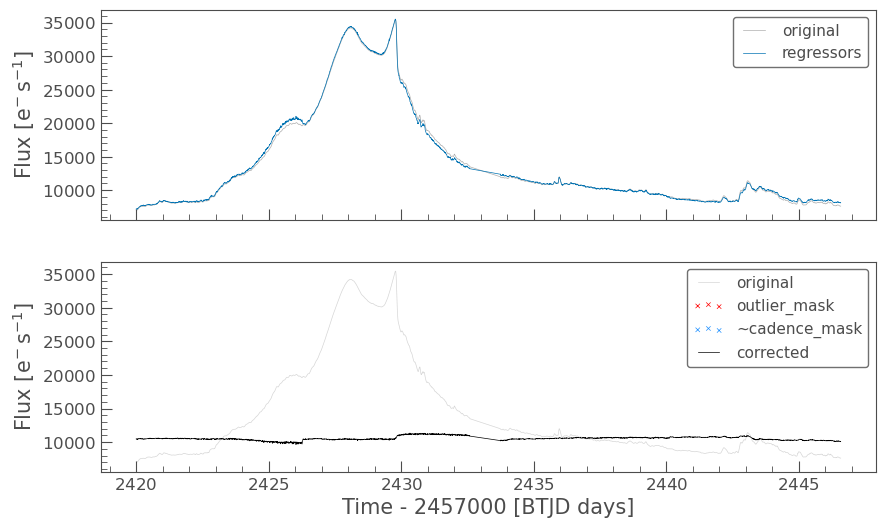

In [22]:
corrector.diagnose();

In [23]:
corrector.model_lc

time,flux,flux_err
,electron / s,electron / s
Time,float64,float64
2420.0006367159403,-3418.0252222442787,0.0
2420.0075813185713,-3432.351880936856,0.0
2420.014525921202,-3415.332696974395,0.0
2420.021470523833,-3440.9942121701397,0.0
2420.0284151259984,-3423.190436068455,0.0
2420.0353597281637,-3340.0782453666043,0.0
2420.042304330329,-3441.6181163052242,0.0
2420.0492489320286,-3382.53071282378,0.0


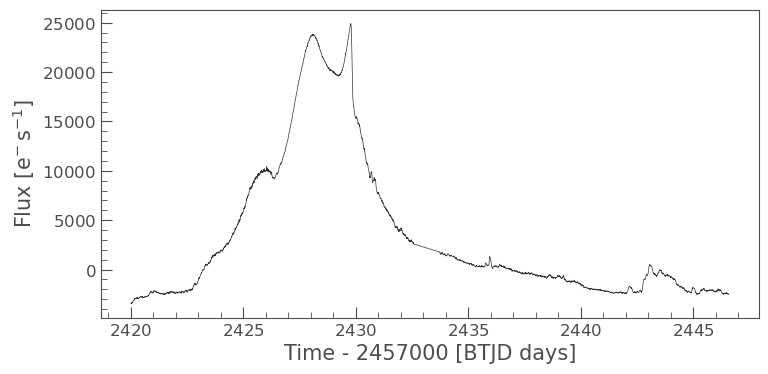

In [24]:
model = corrector.model_lc
model.plot();

In [25]:
# Normalize to the 5th percentile of model flux
model -= np.percentile(model.flux, 5)

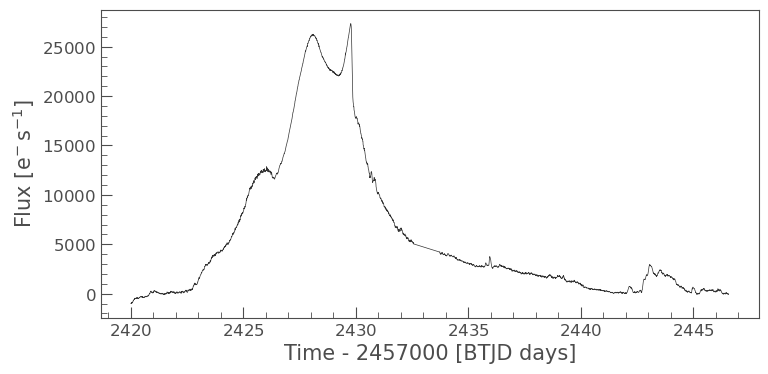

In [26]:
model.plot();

In [27]:
corrected_lc = uncorrected_lc - model

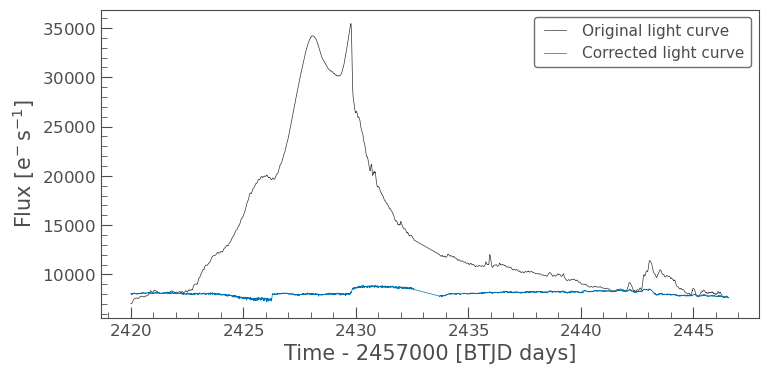

In [28]:
ax = uncorrected_lc.plot(label='Original light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');

## What happens to the periodic signal
The overall lightcurve shape has changed dramatically. Now let's see what's happening with the 0.1277 day periodic signal...

In [29]:
def simple_detrend_and_period_search(lc, period_range=(0.05, 3.0), titleprefixstring=""):
    """
    Process a LightCurve: clip outliers, detrend, and perform Lomb-Scargle period search.

    Parameters:
    lc (LightCurve): The LightCurve object to process.
    period_range (tuple): The range of periods (in days) to search for periods, default is (0.05, 3.0).
    titleprefixstring (str): A prefix string for titles in the generated plots.

    Returns:
    float: The best period detected by the Lomb-Scargle periodogram.

    Workflow:
    1. Clip Outliers (3-sigma): Removes significant outliers from the lightcurve to clean the data.
    2. Detrend the LightCurve: Uses a 5th-degree polynomial to remove long-term trends.
    3. Re-clip After Detrending: Removes outliers after detrending.
    4. Lomb-Scargle Period Analysis:
       - Converts the specified period range into frequency range.
       - Computes the Lomb-Scargle periodogram.
       - Identifies the best period (highest power).
    5. Generate Plots:
       - Display the sigma-clipped lightcurve.
       - Display the detrended lightcurve.
       - Display the sigma-clipped lightcurve after detrending.
       - Plot the Lomb-Scargle periodogram as a function of frequency, highlighting the best period.
   
    """
    # Step 1: Clip the lightcurve at 3-sigma
    clipped_lc = lc.remove_outliers(sigma=3)
    clipped_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped")
    plt.show()

    # Step 2: Detrend the lightcurve using using scipy's Savitzky-Golay filter wrapped in lc.flatten()
    detrended_lc = clipped_lc.flatten(window_length=101, polyorder=5)
    detrended_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped, detrended")
    plt.show()
    
    # Step 2.5: Clip the lightcurve again (to remove mini-flares in nova V606 Vul lightcurve)
    detrended_lc = detrended_lc.remove_outliers(sigma=3)
    detrended_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped, detrended, sigma-clipped")
    plt.show()    

    # Step 3: Perform Lomb-Scargle periodogram analysis using LightKurve's built-in functionality
    min_period, max_period = period_range
    min_frequency = 1 / max_period
    max_frequency = 1 / min_period

    # Create the periodogram
    periodogram = detrended_lc.to_periodogram(method="lombscargle", 
                                              minimum_frequency=min_frequency, 
                                              maximum_frequency=max_frequency)

    # Find and print the best period
    best_period = periodogram.period_at_max_power
    print(f"The best period is: {best_period:.4f} days")

    # Step 4: Plot the periodogram as a function of frequency
    plt.figure(figsize=(10, 5))
    plt.plot(periodogram.frequency.value, periodogram.power, label="Lomb-Scargle Power")
    plt.axvline(x=1/best_period.value, color="red", linestyle="--", label=f"Best Period = {best_period:.4f} days")
    plt.xlabel("Frequency (1/day)")
    plt.ylabel("Power")
    plt.title(f"{titleprefixstring} Lomb-Scargle Periodogram")
    plt.legend()
    plt.grid()
    plt.show()

    return best_period.value


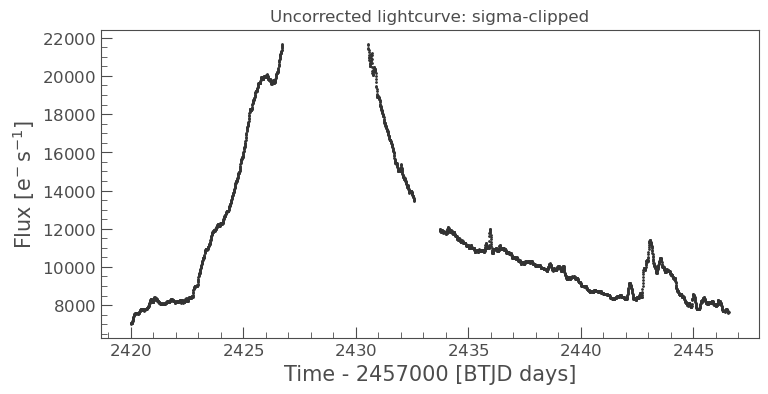

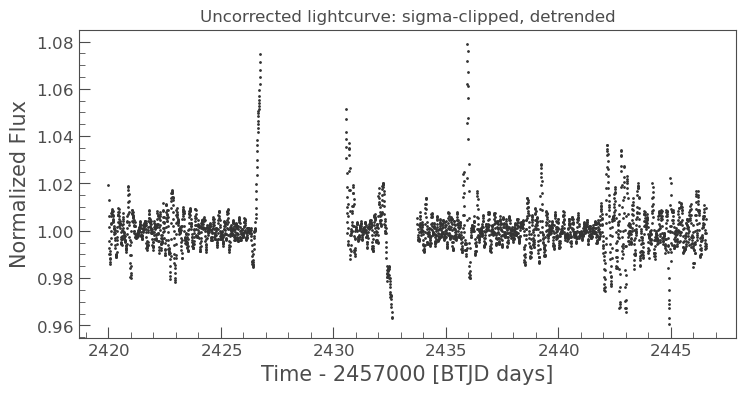

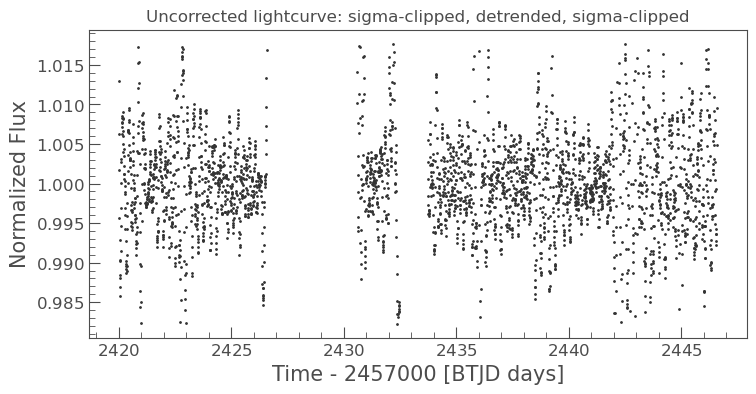

The best period is: 0.1280 d days


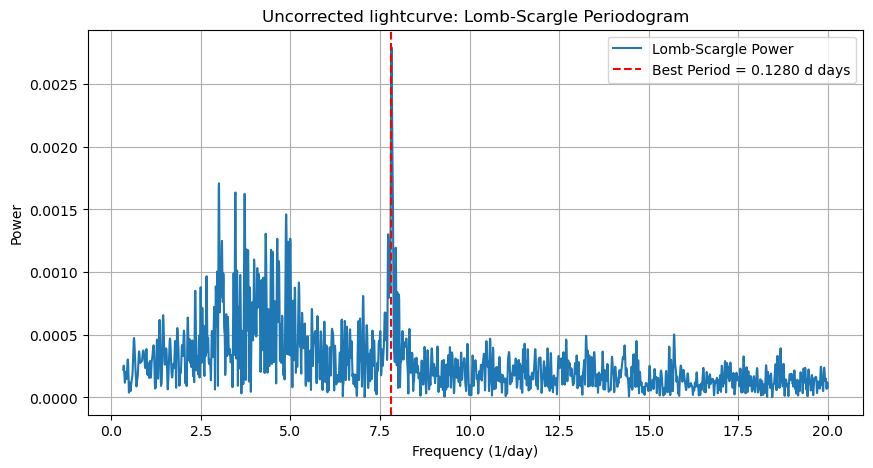

0.1279501706679125

In [30]:
# Extract periodicity from the raw (uncorrectred) lightucrve
simple_detrend_and_period_search(uncorrected_lc, period_range=(0.05, 3.0), titleprefixstring="Uncorrected lightcurve:")

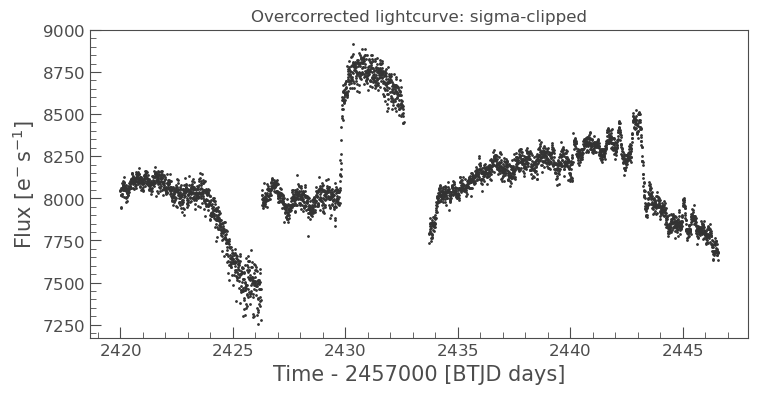

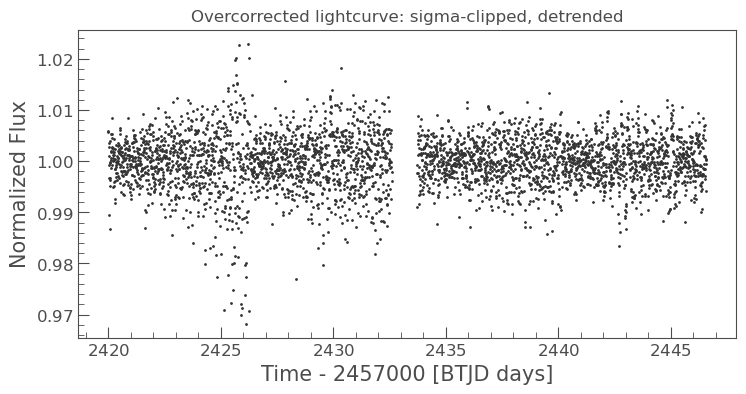

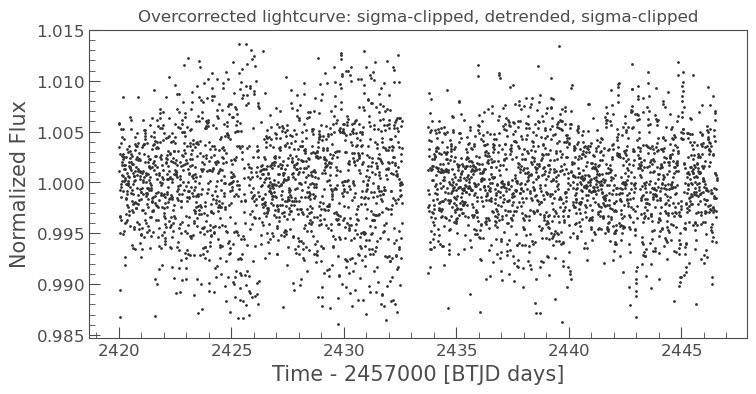

The best period is: 0.3328 d days


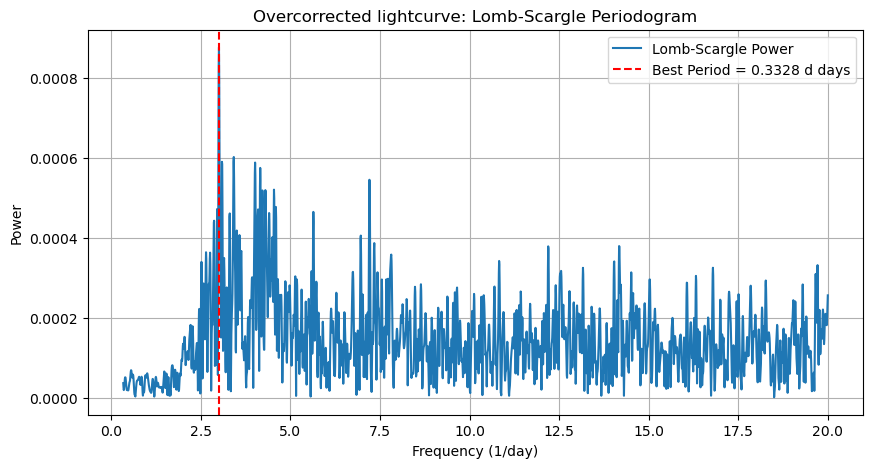

0.3327950219971399

In [31]:
# Extract periodicity from the overcorrectred lightucrve
simple_detrend_and_period_search(corrected_lc, period_range=(0.05, 3.0), titleprefixstring="Overcorrected lightcurve:")

The 0.1277 day periodic signal has been completely wiped out from the lightcurve. Ironically, the 0.333 day modulation, known from the additional analysis to be instrumental, is still detectable in the overcorrected lightcurve.